## Introduction

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

In recent years dengue fever has been spreading. Historically, the disease has been most prevalent in Southeast Asia and the Pacific islands. These days many of the nearly half billion cases per year are occurring in Latin America.


## Problem Statement
Your task is to predict the number of dengue cases each week (in each location) based on environmental variables describing changes in temperature, precipitation, vegetation, using environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce.


## Approach
To predict the number of dengue cases each week, we relied on traditional regression and count regression models, such as the Linear Regression with regularization and rounded our answer to the nearest integer, as well as Negative Binomial and Poisson regression models.

As most of the 'good' features (features which were correlated with the total number of dengue cases) in the Iquitos dataset were present in the San Juan dataset, we use an arbitrary correlation threshold of 0.20 (from the Iquitos dataset) to decide which features to use in the prediction of total dengue cases each week.

Our metric of choice follows closely to how our prediction will be judged - Mean Absolute Loss. After hyperparameter tuning using KFolds, the best model of each class were evaluated against the cross validation dataset. The model of choice is the **Negative Binomial Regression Model** as it did the best on the cross validation dataset.

## Evaluation
Our *Mean Absolute Score* (lower is better) using the Negative Binomial Regression Model with 4 features is 25.7233, enough to place us at rank 396 out of 1652 competitors (top 24th percentile).

### Importing key libraries and reading dataframes

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df_train_features = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv', index_col= [0, 1, 2])
df_train_labels = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv', index_col= [0, 1, 2])
df_test = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv', index_col= [0, 1, 2])

### Simple Data Exploratory Analysis, and Imputing Missing Data

As we are predicting total dengue cases for different cities, we split the datasets into the San Juan dataset and the Iquitos dataset, and conduct simple explanatory analysis on the datasets.

In [3]:
sj_train_features = df_train_features.loc['sj']
iq_train_features = df_train_features.loc['iq']

sj_test_features = df_test.loc['sj']
iq_test_features = df_test.loc['iq']

sj_train_labels = df_train_labels.loc['sj']
iq_train_labels = df_train_labels.loc['iq']

(1990, 18)

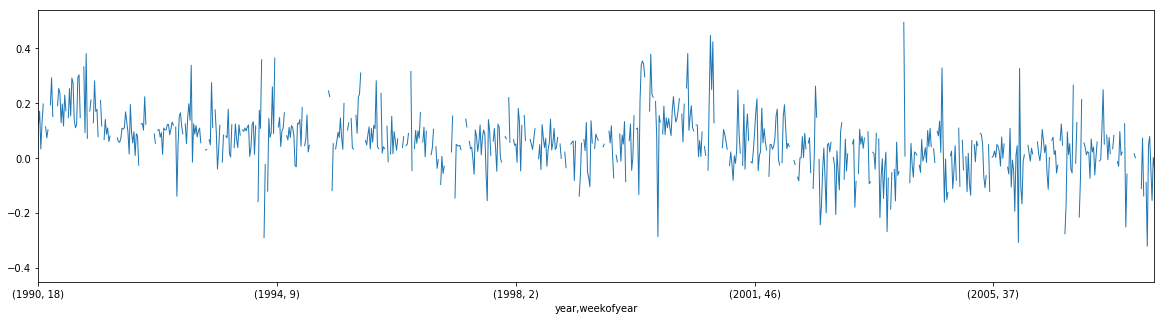

In [4]:
plt.figure(figsize = (20, 5))
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw = 1))

plt.show()

Just by plotting one of the many features in the dataset, it seems to suggest that there are missing values in the dataset. Notice that there are gaps between periods. We now check whether there are any NA values in the other columns.

In [5]:
print sj_train_features.shape
sj_train_features.isnull().any(axis = 0)

(936, 21)


week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                        True
station_precip_mm                         True
dtype: bool

In [23]:
print iq_train_features.shape
iq_train_features.isnull().any(axis = 0)

(520, 21)


ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
total_cases                              False
dtype: bool

Leveraging on structure of the dataset, we fill the NA values with the most recent observation. This can be done by calling the function:
```python
.fillna(method = 'ffill')
```

In [6]:
sj_train_features.sort_index(inplace = True)
sj_train_features.fillna(method = 'ffill', inplace = True)
sj_test_features.fillna(method = 'ffill', inplace = True)

iq_train_features.sort_index(inplace = True)
iq_train_features.fillna(method = 'ffill', inplace = True)
iq_test_features.fillna(method = 'ffill', inplace = True)

After the imputation of missing data, we drop the 'week_start_date' variable, as it is not immediately clear to us if the variable will be any useful in predicting total dengue cases for the two cities.

In [7]:
sj_train_features.drop('week_start_date', axis = 1, inplace = True)
                       
iq_train_features.drop('week_start_date', axis = 1, inplace = True)

We now check for the correlation between the different features by means of a heatmap.

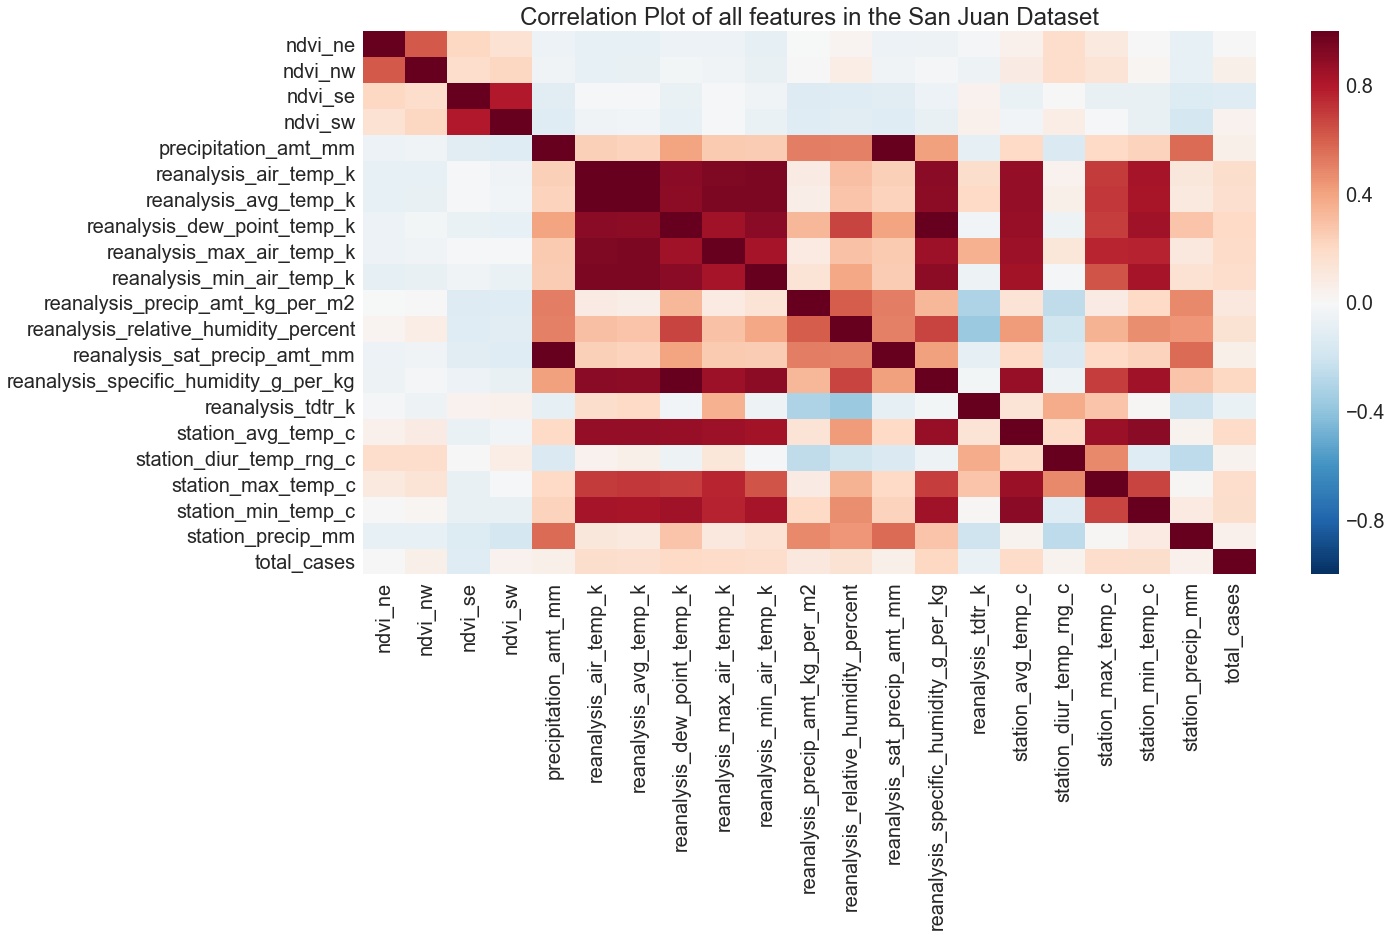

In [8]:
import seaborn as sns

sj_train_features['total_cases'] = sj_train_labels['total_cases']

sj_corr = sj_train_features.corr()

sns.set(font_scale = 2)
plt.figure(figsize=(20, 10))

sns.heatmap(sj_corr)
plt.title('Correlation Plot of all features in the San Juan Dataset')
plt.show()

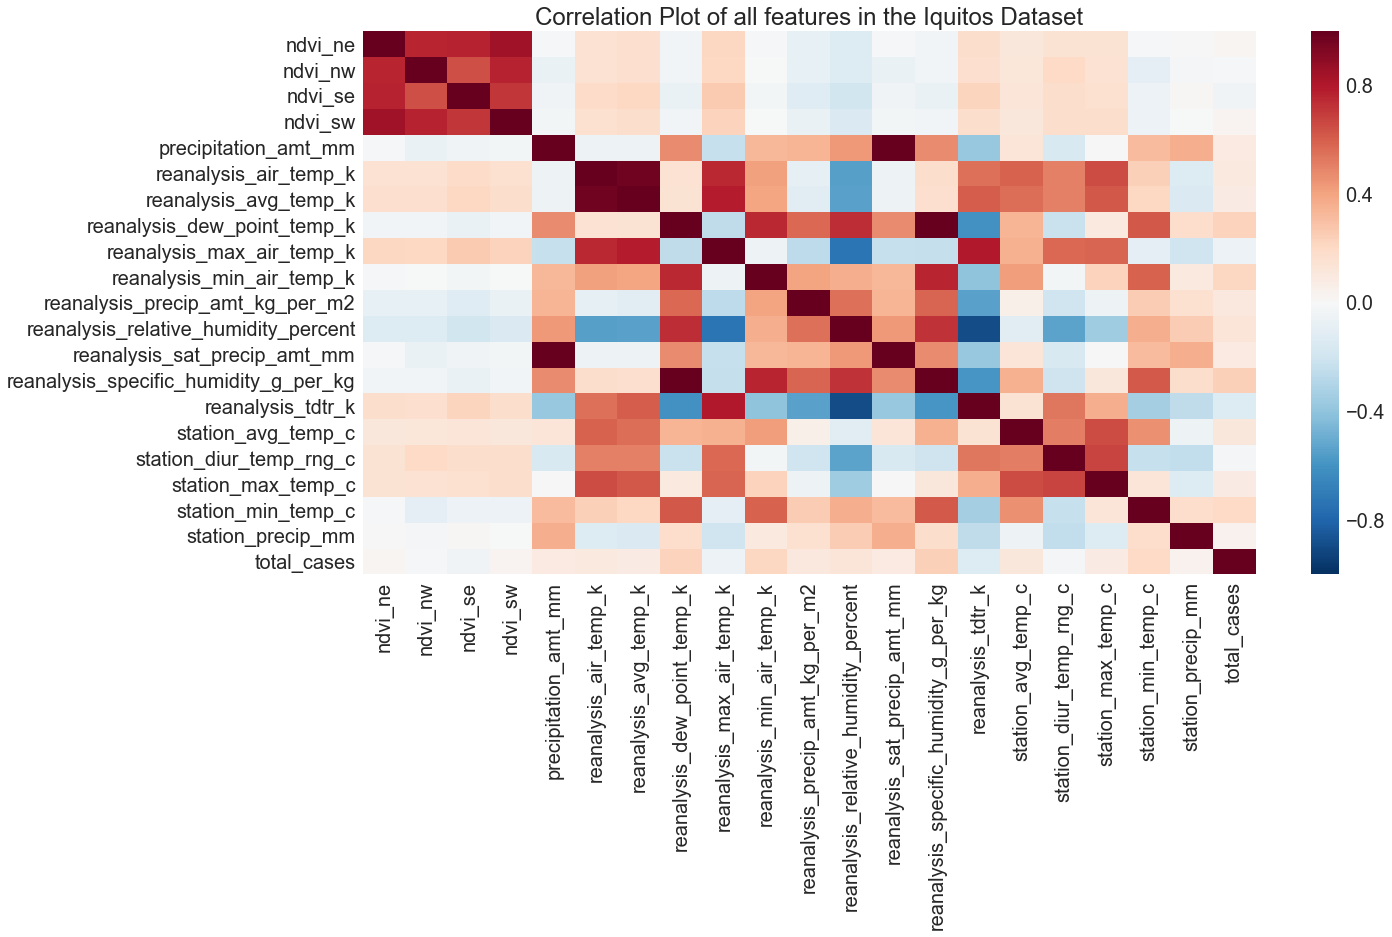

In [9]:
iq_train_features['total_cases'] = iq_train_labels['total_cases']

iq_corr = iq_train_features.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(iq_corr)
plt.title('Correlation Plot of all features in the Iquitos Dataset')
plt.show()

We note the following for both the datasets:

* No variables are exceptionally good at predicting the label (total cases)

* The first 4 variables (Normalized Difference Vegetation Index) variables appears to be very weakly correlated with the other variables. They do not appear to be very useful in predicting the labels.

* Most of temperature variables in both datasets appear to be strongly correlated with one another.

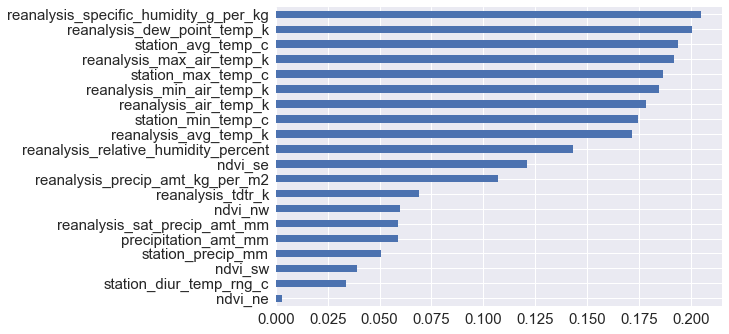

In [10]:
sns.set(font_scale = 1.5)
(abs(sj_corr)
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

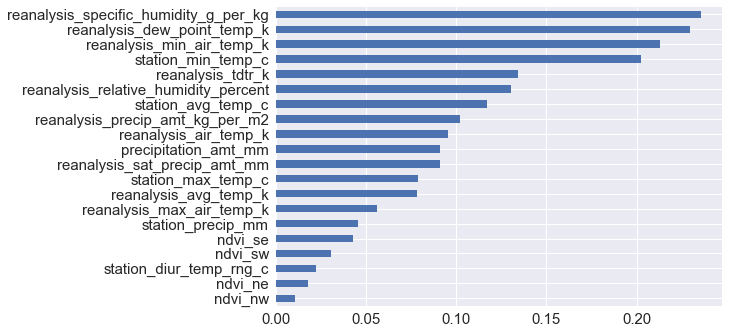

In [11]:
sns.set(font_scale = 1.5)
(abs(iq_corr)
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

it appears that certain variables feature prominently on both bar charts, suggesting that they may be commmon drivers of dengue cases. For example, specific humidity (in g/kg), dew point temperature (in K), [reanalysis] minimum air temperature (in K) and [station] minimum air temperature (in C) appear to be relatively strongly correlated with the *total_cases* label. 

Lastly, how does the distribution of the total cases look like?

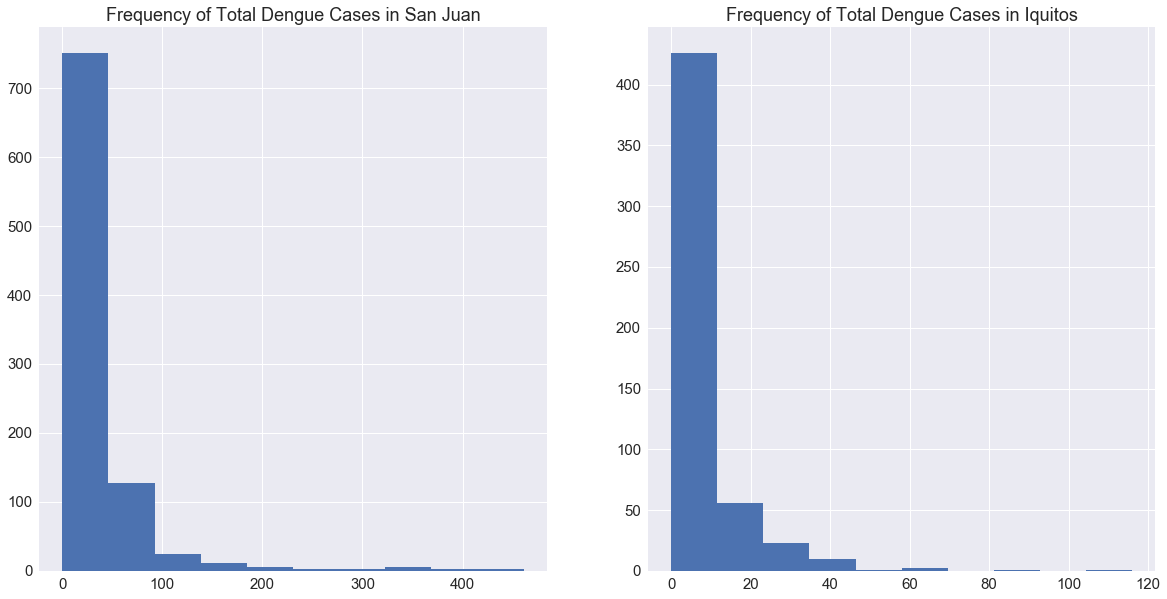

In [242]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.hist(sj_train_features['total_cases'])
plt.title('Frequency of Total Dengue Cases in San Juan')

plt.subplot(1, 2, 2)
plt.hist(iq_train_features['total_cases'])
plt.title('Frequency of Total Dengue Cases in Iquitos')

plt.show()

The toal cases variable appear to follow either an Exponential Distribution or a Negative Binomial Distribution. To check whether we are able to use a Poisson Distribution to model the variable, we check whether the mean and variance of the series are similar to one another.

In [244]:
print 'Mean of San Juan test cases: ', np.mean(sj_train_labels.values)
print 'Variance of San Juan test cases: ', np.var(sj_train_labels.values)

print '\nMean of Iquitos test cases: ', np.mean(iq_train_labels.values)
print 'Variance of Iquitos test cases: ', np.var(iq_train_labels.values)

Mean of San Juan test cases:  34.1805555556
Variance of San Juan test cases:  2637.22487832

Mean of Iquitos test cases:  7.56538461538
Variance of Iquitos test cases:  115.672647929


It appears that the mean and variance of the dataset are not similar to another. Hence, the Poisson Regression Model may not be the best model in predicting the total number of dengue cases in this case.

### Splitting into training, cross-validation and testing dataset

After conducting our simple exploratory data analysis, we proceed to split the dataset into training and cross validation dataset. This can be done by calling the function:
```python
train_test_split
```

Noting that we will be using the temporal aspect of the dataframe, we split the dataset purposefully, with the first 750 observations set as our training set for the San Juan dataset.

In [245]:
from sklearn.model_selection import train_test_split

X_sj = sj_train_features.ix[:, 0:20]
y_sj = sj_train_features['total_cases']
X_sj_train, y_sj_train = X_sj.ix[:750, :], y_sj[0:750]
X_sj_cv, y_sj_cv = X_sj.ix[751:, :], y_sj[751:]

In [246]:
X_iq = iq_train_features.ix[:, 0:20]
y_iq = iq_train_features['total_cases'] 
X_iq_train, y_iq_train = X_iq.ix[:360, :], y_iq[0:360]
X_iq_cv, y_iq_cv = X_iq.ix[361:, :], y_iq[361:]

### Feature Selection and Processing

Given that there are common drivers between the two cities (as previously identified), we use these common variables in our prediction of total dengue cases.

In [249]:
imptVar = abs(iq_corr).total_cases.drop('total_cases').sort_values(ascending = False).index[0:4]

In [250]:
X_sj_temp_train = X_sj_train[imptVar] 
X_sj_temp_cv = X_sj_cv[imptVar]
X_sj_temp_test = sj_test_features[imptVar]

X_iq_temp_train = X_iq_train[imptVar] 
X_iq_temp_cv = X_iq_cv[imptVar]
X_iq_temp_test = iq_test_features[imptVar]

In [251]:
X_sj_temp_train['y'] =  y_sj_train.values
X_sj_temp_cv['y'] = y_sj_cv.values

X_iq_temp_train['y'] = y_iq_train.values
X_iq_temp_cv['y'] = y_iq_cv.values

We are ready to start generating several models to predict the total number of dengue cases in San Juan and Iquitos.

In [252]:
print sj_train_features.index[0] # The date 
print iq_train_features.index[0]

(1990, 18)
(2000, 26)


In [254]:
sj_rng = pd.date_range('30/04/1990', periods = len(sj_train_features), freq = 'W')
iq_rng = pd.date_range('26/06/2000', periods = len(iq_train_features), freq = 'W')

In [255]:
X_sj_temp_train.index = sj_rng[:750]
X_sj_temp_cv.index = sj_rng[751:]

X_iq_temp_train.index = iq_rng[:360]
X_iq_temp_cv.index = iq_rng[361:]

### Model Fitting

Previously, we have seen that the distribution of the total cases appear to follow either an Exponential or Negative Binomial Distribution.

#### Negative Binomial Regression Model

We attempt to find the best fitting Negative Binomial Model by tweaking the hyperparameter, alpha, between the range of 0.01 and 2.

In [266]:
imptVar

Index([u'reanalysis_specific_humidity_g_per_kg',
       u'reanalysis_dew_point_temp_k', u'reanalysis_min_air_temp_k',
       u'station_min_temp_c'],
      dtype='object')

In [273]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def best_nb_model(train, cv):
    formula =  "y ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "reanalysis_min_air_temp_k + " \
                    "station_min_temp_c" 
    alpha_grid = np.linspace(0.01, 2, 100)
    
    best_alpha = 0; best_mae = 1000
    
    for alpha in alpha_grid:
        model = smf.glm(formula = formula, data = train,
                        family = sm.families.NegativeBinomial(alpha = alpha))
        nb_model = model.fit()
        
        cv_pred = map(int, map(round, nb_model.predict(cv)))
        mae = eval_measures.meanabs(cv_pred, cv.y)
        
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha
            
    total = pd.concat([train, cv])
    
    print 'Negative Binomial Model: ', best_mae
    return smf.glm(formula = formula, data = total,
                   family = sm.families.NegativeBinomial(alpha = best_alpha)).fit()

#### Poisson Model

Previously, we have observed that the distribution of the total cases do not follow a Poisson distribution. Here, we check to see if the Poisson model might do better in predicting total cases.

In [274]:
def best_poisson_model(train, cv):
    formula =  "y ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "reanalysis_min_air_temp_k + " \
                    "station_min_temp_c" 
    
    model = smf.glm(formula = formula, data = train,
                    family = sm.families.Poisson())
    poisson_model = model.fit()
        
    cv_pred = map(int, map(round, poisson_model.predict(cv)))
    mae = eval_measures.meanabs(cv_pred, cv.y)
        
    total = pd.concat([train, cv])
    
    print 'Poisson Regression Model: ', mae
    return smf.glm(formula = formula, data = total,
                   family = sm.families.Poisson()).fit()

#### Linear Regression with L2 Regularization (Ridge)

For our third model, we use the Ridge Regression model.

In [276]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def best_ridge_model(train, cv):
    ridge = Ridge(random_state = 10)
    
    param_grid = {'alpha': np.logspace(-5, 3, 50)}
    
    model = GridSearchCV(ridge, param_grid, scoring = 'neg_mean_absolute_error', cv = 10)
    
    X_var = imptVar
    ridgereg = model.fit(train[X_var], train.y)
        
    cv_pred = map(int, map(round, ridgereg.predict(cv[X_var])))
    mae = eval_measures.meanabs(cv_pred, cv.y)
        
    total = pd.concat([train, cv])
    
    print 'Ridge Regression Model: ', mae
    return model.fit(total[X_var], total.y)

#### Linear Regression with L1 Regularization (Lasso)
For our fourth model, we use the Lasso Regression model.

In [277]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

def best_lasso_model(train, cv):
    lasso = Lasso(random_state = 10)
    
    param_grid = {'alpha': np.logspace(-5, 3, 50), }
    
    model = GridSearchCV(lasso, param_grid, scoring = 'neg_mean_absolute_error', cv = 10)
    
    X_var = imptVar
    lassoreg = model.fit(train[X_var], train.y)
        
    cv_pred = map(int, map(round, lassoreg.predict(cv[X_var])))
    mae = eval_measures.meanabs(cv_pred, cv.y)
        
    total = pd.concat([train, cv])
    
    print 'Lasso Regression Model: ', mae
    return model.fit(total[X_var], total.y)

#### Time Series Regression Model
For our last model, we will use an Autoregressive Integrated Moving Average (ARIMA) model. To determine then amount of lags to use for each component, we first check if the series contains a unit root.

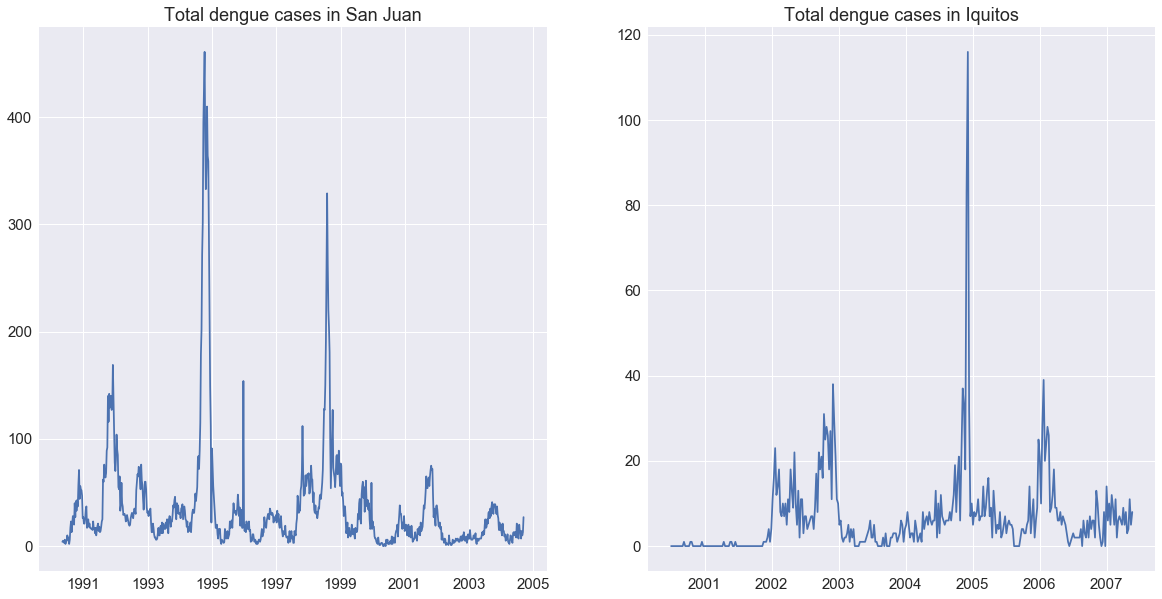

In [260]:
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot_date(X_sj_temp_train.index, X_sj_temp_train.y.values, '-')
plt.title('Total dengue cases in San Juan')

plt.subplot(1, 2, 2)
plt.plot_date(X_iq_temp_train.index, X_iq_temp_train.y.values, '-')
plt.title('Total dengue cases in Iquitos')

plt.show()

The series does not appear to be trending.

In [261]:
adf_sj_test = adfuller(X_sj_temp_train.y)
adf_iq_test = adfuller(X_iq_temp_train.y)
    
print('ADF Statistic: %f' % adf_sj_test[0])
print('p-value: %f' % adf_sj_test[1])
print('Critical Values:' )
for key, value in adf_sj_test[4].items():
    print('\t%s: %.3f' % (key, value))
    
print '\n'
print('ADF Statistic: %f' % adf_iq_test[0])
print('p-value: %f' % adf_iq_test[1])
print('Critical Values:' )
for key, value in adf_iq_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.635065
p-value: 0.000111
Critical Values:
	5%: -2.865
	1%: -3.439
	10%: -2.569


ADF Statistic: -5.123416
p-value: 0.000013
Critical Values:
	5%: -2.870
	1%: -3.449
	10%: -2.571


As it turns out, as the p-value from the Augmented Dickey Fuller Test < 1%, we reject the null hypothesis that we are dealing with a stationary series, i.e. our series contains a unit root. As we have exogenus variables, we include them in the specification of the model.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  749
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3137.816
Method:                       css-mle   S.D. of innovations             15.964
Date:                Sun, 23 Jul 2017   AIC                           6293.633
Time:                        14:51:15   BIC                           6335.201
Sample:                    05-13-1990   HQIC                          6309.651
                         - 09-12-2004                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0245      0.628      0.039      0.969      -1.207       1.256
reanalysis_specific_humidity_g_per_kg    17.8288  

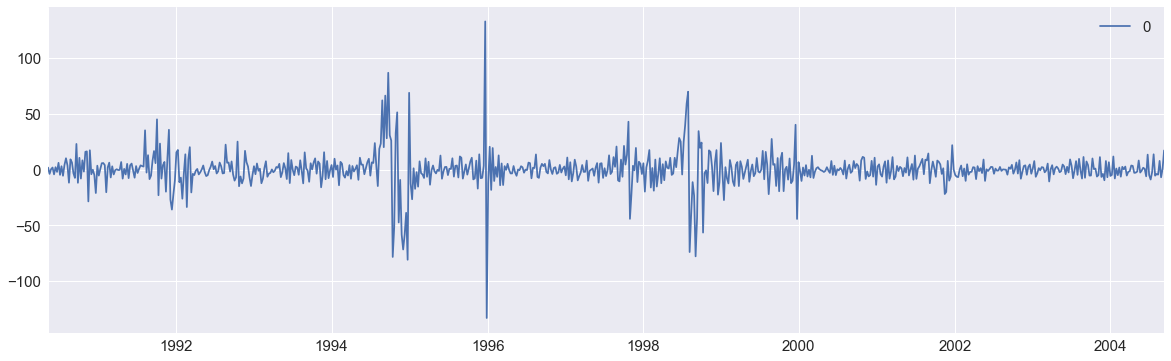

In [335]:
def time_sj_series(train):
    series = map(float, X_sj_temp_train.y)
    model = sm.tsa.ARIMA(series, order = (2, 1, 1), exog = X_sj_temp_train[imptVar].diff())
    model_fit = model.fit()
    print(model_fit.summary())
    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(figsize = (20, 6))
    plt.show()
    return model_fit
    
tsa_sj = time_sj_series(X_sj_temp_train)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  359
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1204.663
Method:                       css-mle   S.D. of innovations              6.899
Date:                Sun, 23 Jul 2017   AIC                           2429.327
Time:                        14:51:21   BIC                           2468.160
Sample:                    07-09-2000   HQIC                          2444.769
                         - 05-20-2007                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0197      0.015      1.282      0.201      -0.010       0.050
reanalysis_specific_humidity_g_per_kg     1.5461  

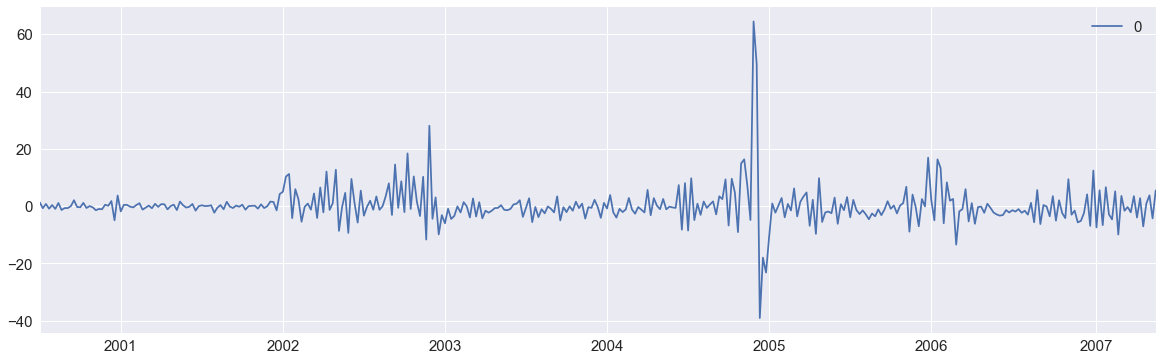

In [336]:
def time_iq_series(train):
    series = map(float, X_iq_temp_train.y)
    model = sm.tsa.ARIMA(series, order = (3, 1, 1), exog = X_iq_temp_train[imptVar].diff())
    model_fit = model.fit()
    print(model_fit.summary())
    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(figsize = (20, 6))
    plt.show()
    return model_fit
    
tsa_iq = time_iq_series(X_iq_temp_train)

It appears that an ARIMA(3, 1, 1) model appears to describe  the underlying data pretty well. We shall use our model to predict for the cross-validation data.

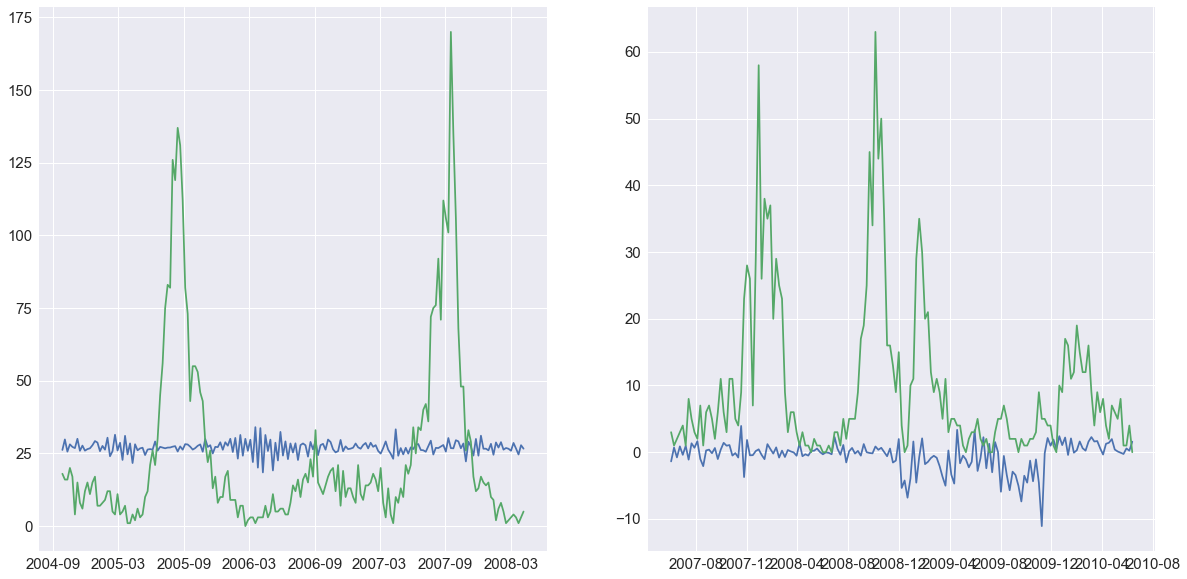

In [346]:
forecast_sj = tsa_sj.predict(1, len(X_sj_temp_cv), 
                             exog = X_sj_temp_cv[imptVar]) + X_sj_temp_train.y.values[-1]
forecast_iq = tsa_iq.predict(1, len(X_iq_temp_cv), 
                             exog = X_iq_temp_cv[imptVar]) + + X_iq_temp_cv.y.values[-1]

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot(X_sj_temp_cv.index, forecast_sj,
         X_sj_temp_cv.index, X_sj_temp_cv.y)

plt.subplot(1, 2, 2)
plt.plot(X_iq_temp_cv.index, forecast_iq,
         X_iq_temp_cv.index, X_iq_temp_cv.y)

plt.show()

In [348]:
def min_0(x): return(max(x, 0))
def time_series_forecast(pred, cv, train):
    forecast = pred.predict(1, len(cv), exog = cv.ix[imptVar].diff()).cumsum() + train.y.values[-1]
    print 'Time Series Regression Model: ', eval_measures.meanabs((map(min_0, forecast)), 
                                                                  cv.y.values)

Time Series Regression Model:  27.5409150844
Time Series Regression Model:  8.56191279286


In [349]:
best_nb_model(X_sj_temp_train, X_sj_temp_cv)
best_nb_model(X_iq_temp_train, X_iq_temp_cv)

best_poisson_model(X_sj_temp_train, X_sj_temp_cv)
best_poisson_model(X_iq_temp_train, X_iq_temp_cv)

best_ridge_model(X_sj_temp_train, X_sj_temp_cv)
best_ridge_model(X_iq_temp_train, X_iq_temp_cv)

best_lasso_model(X_sj_temp_train, X_sj_temp_cv)
best_lasso_model(X_iq_temp_train, X_iq_temp_cv)

time_series_forecast(tsa_sj, X_sj_temp_cv, X_sj_temp_train)
time_series_forecast(tsa_iq, X_iq_temp_cv, X_iq_temp_train)

Negative Binomial Model:  24.8
Negative Binomial Model:  7.08176100629
Poisson Regression Model:  24.8810810811
Poisson Regression Model:  7.08176100629
Ridge Regression Model:  25.6378378378
Ridge Regression Model:  7.22012578616
Lasso Regression Model:  26.0540540541
Lasso Regression Model:  7.2893081761
Time Series Regression Model:  27.5409150844
Time Series Regression Model:  8.56191279286


It turns out that the Negative Binomial Regression Model performs the best on both the San Juan and the Iquitos datasets.

In [350]:
best_sj_model = best_nb_model(X_sj_temp_train, X_sj_temp_cv)
best_iq_model = best_nb_model(X_iq_temp_train, X_iq_temp_cv)

Negative Binomial Model:  24.8
Negative Binomial Model:  7.08176100629


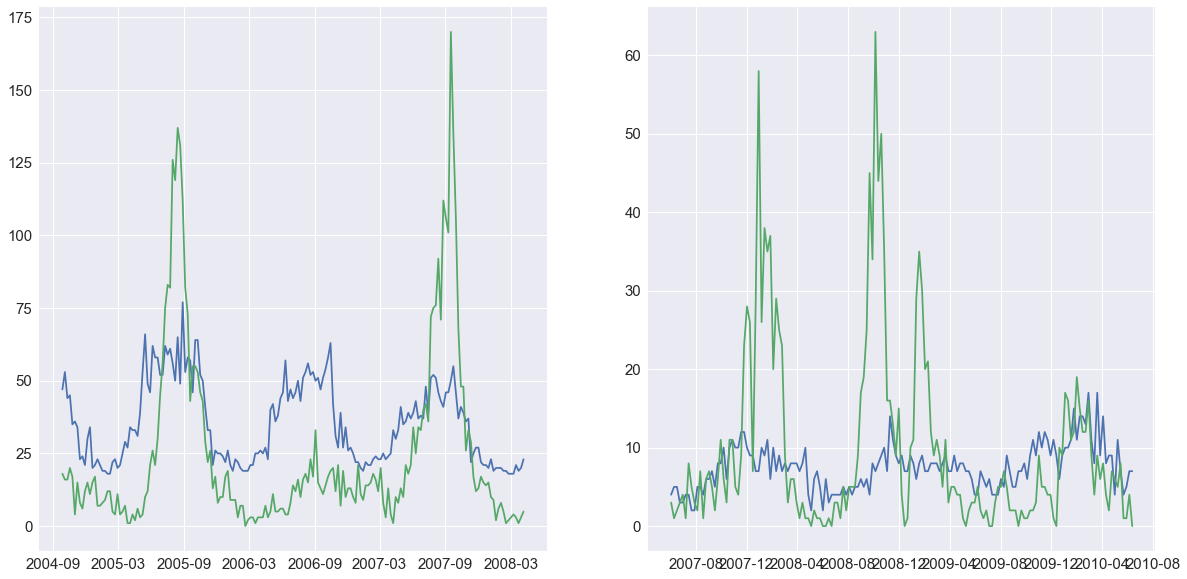

In [352]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot(best_sj_model.predict(X_sj_temp_cv).astype(int), '-')
plt.plot(X_sj_temp_cv.y, '-')

plt.subplot(1, 2, 2)
plt.plot(best_iq_model.predict(X_iq_temp_cv).astype(int), '-')
plt.plot(X_iq_temp_cv.y, '-')

plt.show()

Our predictions are much more muted and unable to capture major fluctuations in total dengue cases across the two areas.

In [353]:
y_sj_test = pd.Series(map(int, map(round, best_sj_model.predict(X_sj_temp_test))))
y_iq_test = pd.Series(map(int, map(round, best_iq_model.predict(X_iq_temp_test))))

In [354]:
submission = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Submission_Format.csv')

submission_ = y_sj_test.append(y_iq_test, ignore_index=True)

In [356]:
submission_.head()

0    26
1    26
2    29
3    25
4    28
dtype: int64

In [357]:
submission['total_cases'] = submission_

In [358]:
submission.to_csv('submission.csv', index = False)